<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Brachistochrone_and_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive permissions

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


# Imports and Global Values

In [3]:
from random import shuffle,randint,sample,random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from time import sleep
from datetime import datetime, date
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob
from PIL import Image, ImageSequence

base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project"
counter = 0

date_string = date.today()
base_name = f'GD_Brach__{date_string}'
gif_dir = os.path.join(base_path, "gifs/" + base_name)
misc_runs_dir = os.path.join(base_path, "misc_runs/" + base_name)


print('Done')

Done


# Genetic Algorithm Generation

## Brachistochrone

In [4]:
class Brachistochrone:
  def __init__(self, N=20, height=1.0, **kwargs):
      # height is as a ratio of the width.
      # N is the number of *segments*, that is, "blocks", not points (which will be N+1).
      # The state is the height of each point, so will be length N+1.
      # To make things easy, I'll also have an xpos list.
      self.N_segments = N
      self.N_pts = N+1
      self.width = 1.0
      self.height = height
      self.state = [self.height]
      self.xpos = [0]
      self.delta_x = self.width/self.N_segments

      self.sameness_thresh = kwargs.get('sameness_thresh', 1*10.0**(-5))

      self.same_thresh_decay_steps = kwargs.get('same_thresh_decay_steps', None)

      if self.same_thresh_decay_steps is None:
          self.same_thresh_decay_factor = 1.0
      else:
          self.same_thresh_decay_factor = (10.0**-4)**(1.0/self.same_thresh_decay_steps)

      self.mutate_strength_height_frac = kwargs.get('mutate_strength_height_frac', 1/20.0)
      self.mutate_strength = self.height*self.mutate_strength_height_frac
      self.mutate_all_chance = kwargs.get('mutate_all_chance', 0.0)

      for i in range(self.N_segments-1):
          self.xpos.append((i+1)*self.delta_x)
          #self.state.append(random()*self.height)
          frac = 1
          self.state.append(-self.height/frac + random()*(self.height - (-self.height/frac)))

      self.xpos.append(1.0)
      self.state.append(0)

      #Maybe at some point, try something where it starts with very few points, solves as good
      #as it can with them, and then doubles the number of points, in between

      self.sol = None

      #This is just assuming it dropping vertically and then going horizonally at that speed; it doesn't have to be perfect.
      g = 9.8
      t1 = sqrt(2*self.height/g)
      v1 = g*t1
      t2 = self.width/v1
      self.max_FF = 40*(t1 + t2)

      self.getBrachistochroneSol()



  def getBrachistochroneSol(self):
      w = self.width
      h = self.height

      #This is all solved with the assumption that the starting point,
      #where the bead is dropped, is (0,0), meaning that the ending point is
      #(w,-h). See https://math.stackexchange.com/questions/889187/finding-the-equation-for-a-inverted-cycloid-given-two-points
      #Importantly, this means that what you'll inevitably get will be in that coord. system.
      #So, to match it up with the coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

      f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
      t = fsolve(f_t,3.14)[0]

      a = w/(t-sin(t))

      '''print('a:',a)
      print('t:',t)'''

      self.t_range = np.linspace(0,t,self.N_pts)

      self.x = lambda t: a*(t-np.sin(t))
      self.y = lambda t: h + a*(np.cos(t)-1)

      self.sol = (self.t_range, self.x, self.y)

      sol_numeric_y = []

      for x_pt in self.xpos:
          f = lambda t: self.x(t)-x_pt
          tval = fsolve(f,3.14)[0]
          sol_numeric_y.append(self.y(tval))

      temp_state = self.state
      self.state = sol_numeric_y
      self.sol_numeric_y = sol_numeric_y

      self.t_ideal = self.fitnessFunction()
      #print('theoretical best time:',self.t_ideal)

      self.state = temp_state



  def isSameState(self, other_state):

      #return(False)
      max_diff = ((self.N_pts-2)*self.height)**2
      #diff = np.array(self.state) - np.array(other_state.state)
      diff = (np.array(self.state) - np.array(other_state.state))[1:-1]
      #abs_diff = sum(diff**2)
      #if abs_diff/max_diff < self.sameness_thresh
      #abs_diff_normed = sum(abs(diff/(np.array(self.state)[1:-1])))/(self.N_pts-2)
      #abs_diff_normed = abs(sum(diff/abs(np.array(self.state)[1:-1])))/(self.N_pts-2)
      abs_diff_normed = abs(sum(diff))/(self.N_pts-2)
      if abs_diff_normed < self.sameness_thresh:
          return(True)
      else:
          return(False)

  def solFound(self):

      max_diff = ((self.N_pts-2)*self.height)**2
      diff = np.array(self.state) - np.array(self.sol_numeric_y)
      abs_diff = sum(diff**2)
      thresh = 1*10.0**(-5)
      if abs_diff/max_diff < thresh:
          print('abs_diff/max_diff: {:.3f}'.format(abs_diff/max_diff))
          return(True)
      else:
          return(False)


  def plotState(self, ax, color='black', plot_sol=False, plot_label=False):

      # Pass this an axis from another program. It will handle showing it and stuff.

      #ax.clear()

      if plot_sol:
          t = self.sol[0]
          x = self.sol[1]
          y = self.sol[2]
          ax.plot(x(t), y(t), '-', color='gray')
          if plot_label:
              ax.text(0.8*self.width, 0.9*self.height, 'ideal: {:.3f}'.format(self.t_ideal))

      if plot_label:
          ax.text(0.8*self.width, 0.8*self.height, 'cur. best: {:.3f}'.format(self.fitnessFunction()))

      ax.plot(self.xpos, self.state, 'o-', color=color)


  def mutate(self):
      #inclusive,inclusive
      #index = randint(1, self.N_segments-1)

      self.sameness_thresh *= self.same_thresh_decay_factor

      if random() < self.mutate_all_chance:
          # Mutate all indices by some amount.
          mut_amount = np.random.normal(scale=self.mutate_strength)
          N_mutate = randint(1, self.N_segments-1)
          mutate_indices = sample(list(range(1, self.N_segments)), N_mutate)

          for index in range(1, self.N_segments-1):
              new_height = self.state[index] + mut_amount
              if new_height < self.height:
                  self.state[index] = new_height

      else:
          # Mutate random set of indices
          N_mutate = randint(1, self.N_segments-1)
          mutate_indices = sample(list(range(1, self.N_segments)), N_mutate)

          for index in mutate_indices:
              new_height = self.state[index] + np.random.normal(scale=self.mutate_strength)
              if new_height < self.height:
                  self.state[index] = new_height



  def mutateSingle(self):

      index = randint(1, self.N_segments-1)

      new_height = self.state[index] + np.random.normal(scale=self.mutate_strength)
      if new_height < self.height:
          self.state[index] = new_height


  def fitnessFunction(self):

      g = 9.8

      #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
      d = -np.array([self.state[i+1] - self.state[i] for i in range(self.N_segments)])

      #Be careful with signs and indices!
      v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

      if np.isnan(v).any():
          print('\n\nbad v:',v)
          print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
          print('\nstate',self.state)
          plt.savefig('test_bad_np.png')
          exit(0)


      #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
      v = v[:-1]
      t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + self.delta_x**2))
      '''print('\n\n')
      print('state',self.state)
      print('d',d)
      print([sum(d[:(i+1)]) for i in range(len(d))])
      print('v',v)
      print('t',t)'''


      return(sum(t))





  #*************************************** GA stuff

  def mate(self,other_individ):


      #return(self.mateRandomIndices(other_individ))
      return(self.mateCrossover(other_individ))


  def mateRandomIndices(self,other_individ):

      newindivid_1 = deepcopy(self)
      newindivid_2 = deepcopy(other_individ)
      #inclusive, inclusive
      N_switch = randint(1,self.N_segments-1)
      switch_indices = sample(list(range(1,self.N_segments)),N_switch)

      for index in switch_indices:
          temp = newindivid_1.state[index]
          newindivid_1.state[index] = newindivid_2.state[index]
          newindivid_2.state[index] = temp

      return(newindivid_1,newindivid_2)



  def mateCrossover(self,other_individ):

      newindivid_1 = deepcopy(self)
      newindivid_2 = deepcopy(other_individ)
      #inclusive, inclusive
      #index = randint(2,self.N_pts-2)

      r1 = randint(1,self.N_pts-3)
      r2 = randint(r1+1,self.N_pts-2)

      temp = newindivid_1.state[r1:r2]
      newindivid_1.state[r1:r2] = newindivid_2.state[r1:r2]
      newindivid_2.state[r1:r2] = temp

      '''temp = newindivid_1.state[:index]
      newindivid_1.state[:index] = newindivid_2.state[:index]
      newindivid_2.state[:index] = temp'''

      return(newindivid_1,newindivid_2)


  def mateAvg(self,other_individ):

      newindivid_1 = deepcopy(self)
      newindivid_2 = deepcopy(other_individ)

      newindivid_1.state = ((np.array(newindivid_1.state) + np.array(newindivid_2.state))/2).tolist()


      return(newindivid_1,newindivid_1)

print('Class Brachistochrone Created correctly')


Class Brachistochrone Created correctly


## Population

The object must have the following functions or attributes:
 * fitnessFunction()
 * mutate()
 * isSameState()
 * mate()
 * state (maybe change to getState()?)


In [5]:
class Population:

    def __init__(self, individ_class, popsize, **kwargs):

        self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
        print(self.kwargs_str)

        self.individ_class = individ_class
        print('using', individ_class.__name__, 'class')
        self.class_name = individ_class.__name__
        self.popsize = popsize
        self.population = [self.createNewIndivid(**kwargs) for i in range(self.popsize)]
        self.sorted_population = None

    def createNewIndivid(self, **kwargs):
        return(self.individ_class(**kwargs))

    def printPop(self):
        print('\nPopulation:')
        [print(individ.state) for individ in self.population]
        print('\n\n')

    def printFitnessFunctions(self):
        for individ in self.population:
            individ.printState()
            print(individ.fitnessFunction())

    def sortIndivids(self):
        individs_fitness = [(individ,individ.fitnessFunction(),'old') for individ in self.population]
        individs_fitness = sorted(individs_fitness,key=lambda x: x[1])
        #print(individs_fitness)
        self.sorted_population = individs_fitness

    def sortTupleByFitness(self,tuple_list):
        return(sorted(tuple_list,key=lambda x: x[1]))

    def getBestAndMean(self):
        if self.sorted_population is None:
            return((0,0))

        best = self.sorted_population[0][1]
        mean = sum([individfitness[1] for individfitness in self.sorted_population])/(1.0*len(self.population))
        return((best,mean))

    def deleteDupes(self,pop):
        #Might have to be careful here -- what happens if you delete so many dupes that the pop size is smaller than original?
        #Pass it just a list of individs. But remember that you have to look at individ.state
        #return(list(set(pop)))

        unique_individs = []
        no_dupes = []
        for i,ind1 in enumerate(pop):
            #if ind1.state not in unique_individs:
            is_not_unique = np.any([ind1.isSameState(other) for other in no_dupes])
            if not is_not_unique:
                unique_individs.append(ind1.state)
                no_dupes.append(ind1)

        return(no_dupes)


    def mateTournament(self):

        best_N = max(int(self.popsize/5), 2)
        self.sortIndivids()
        self.population = [x[0] for x in self.sorted_population]

        new_individs = []
        last_ind = min(len(self.population), self.popsize)
        for i in range(best_N):
            for j in range(i+1,best_N):
                b1,b2 = self.population[i].mate(self.population[j])
                #b1,b2 = self.mate(self.population[i],self.population[j])
                new_individs.append(b1)
                new_individs.append(b2)

        self.population = (new_individs + self.population)[:self.popsize]
        [individ.mutate() for individ in self.population]


    def mateGrid(self):

        new_individs = []

        #Mating scheme
        last_ind = min(len(self.population),self.popsize)
        for i in range(last_ind):
            for j in range(i+1,last_ind):
                b1,b2 = self.population[i].mate(self.population[j])
                #b1,b2 = self.mate(self.population[i],self.population[j])
                new_individs.append(b1)
                new_individs.append(b2)

        '''old_and_new_individs = deepcopy(self.population) + new_individs
        [individ.mutate() for individ in old_and_new_individs]
        self.population = old_and_new_individs + self.population'''

        best_individ = deepcopy(self.population[0])
        self.population = self.population + new_individs
        [individ.mutate() for individ in self.population]
        self.population = self.population + [best_individ]

        self.sortIndivids()

        if len(self.sorted_population) > self.popsize:
            self.population = self.deleteDupes([x[0] for x in self.sorted_population])
        else:
            self.population = [x[0] for x in self.sorted_population]

        self.population = self.population[:self.popsize]




    def plotFF(self, ax, best_FF, mean_FF):

        ax.clear()
        ax.set_xlabel('# generations')
        ax.set_ylabel('fitness function')
        ax.plot(best_FF, label='best', color='dodgerblue')
        ax.plot(mean_FF, label='mean', color='tomato')
        ax.legend()
        ax.text(0.6*len(best_FF), 0.8*max(best_FF), 'best: {:.3f}\nmean: {:.3f}'.format(best_FF[-1], mean_FF[-1]))


    def plotEvolve(self,  **kwargs):

        N_gen = kwargs.get('N_gen', 550)
        show_plot = kwargs.get('show_plot', True)
        plot_state = kwargs.get('plot_state', True)
        plot_whole_pop = kwargs.get('plot_whole_pop', False)
        make_gif = kwargs.get('make_gif', False)
        save_best_FF = kwargs.get('save_best_FF', True)

        base_name_temp = f'evolve_{self.class_name}__pop={self.popsize}__gen={N_gen}__{self.kwargs_str}__{date_string}'

        if make_gif:
            N_gif_frames = 100
            gif_dir = os.path.join(base_path, "gifs/" + base_name_temp)
            print(gif_dir)
            subprocess.check_call(['mkdir', gif_dir])

        if plot_state:
            fig, axes = plt.subplots(2,1,figsize=(6,8))
            ax_FF = axes[0]
            ax_state = axes[1]
        else:
            fig, ax_FF = plt.subplots(1,1,figsize=(8,8))

        if show_plot:
            plt.show(block=False)

        sol_found = False

        best = []
        mean = []
        cur_best, cur_mean = 0, 0

        method_list = [func for func in dir(self.individ_class) if callable(getattr(self.individ_class, func))]

        if plot_state and plot_whole_pop:
            NUM_COLORS = self.popsize + 2
            cm = plt.get_cmap('RdBu')
            cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
            scalar_map = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
            pop_plot_color_list = [scalar_map.to_rgba(i) for i in range(NUM_COLORS)][::-1]


        for i in range(N_gen):


            self.sortIndivids()
            cur_best, cur_mean = self.getBestAndMean()


            best.append(cur_best)
            mean.append(cur_mean)

            if i%max(1, int(N_gen/20.0))==0:
                print('Generation {}, current best = {:.3f}, current pop. size = {}'.format(i, cur_best, len(self.population)))

            if 'solFound' in method_list:
                if self.population[0].solFound():
                    print(f'found solution in generation {i}!\n')
                    if 'printState' in method_list:
                        self.population[0].printState()
                    break

            # Plot the current best and mean.
            self.plotFF(ax_FF, best, mean)

            # If we're plotting the state of the population, call their plotState() functions.
            # You can plot either the best member, or the whole pop.
            if plot_state:
                ax_state.clear()

                if plot_whole_pop:
                    for j, ind in enumerate(self.population[::-1]):
                        ind.plotState(ax_state, color=pop_plot_color_list[j])

                self.population[0].plotState(ax_state, color='black', plot_sol=True, plot_label=True)

            if show_plot:
                fig.canvas.draw()

            if make_gif:
                if i==0 or (i%max(1, int(N_gen/N_gif_frames))==0):
                    plt.savefig(f'{gif_dir}/{i+1}.png')

            #self.mateTournament()
            self.mateGrid()


        # Finished


        plt.savefig(f'{misc_runs_dir}/{base_name_temp}.png')

        if save_best_FF:
            np.savetxt(f'{misc_runs_dir}/bestFF_{base_name_temp}.txt', best)

        if make_gif:
            # filepaths
            fp_in = misc_runs_dir + "/*.png"
            fp_out = misc_runs_dir + f"/image{counter+1}.gif"
            make_gif(fp_in, fp_out)

        print('\nending mean = {:.3f}'.format(cur_mean))

        return(self.population[0])

print('Class Population Created correctly')


Class Population Created correctly


## Common Functions

In [6]:
def make_dir(fp_in, fp_out):

  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=200, loop=0)
  
  img = Image.open(fp_out)

def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

print('Done')

Done


In [7]:
def plotFF(ax, best_FF):

    ax.clear()
    ax.set_xlabel('# generations')
    ax.set_ylabel('fitness function')
    ax.plot(best_FF, label='best', color='dodgerblue')
    ax.legend()
    ax.text(0.6*len(best_FF), 0.8*max(best_FF), 'best: {:.3f}'.format(best_FF[-1]))


def fitnessFunction(y_no_end_pts, height):

    g = 9.8
    N_segments = len(y_no_end_pts) + 1
    N = N_segments
    N_pts = N+1
    width = 1.0
    delta_x = width/N_segments
    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    #d = -np.array([y[i+1] - y[i] for i in range(N_segments)])

    y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

    d = torch.stack([-(y[i+1] - y[i]) for i in range(N_segments)])

    #Be careful with signs and indices!
    #v = sqrt(2*g)*np.sqrt([0.0] + [sum(d[:(i+1)]) for i in range(len(d))])
    temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = sqrt(2*g)*torch.sqrt(temp)

    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

    return(sum(t))

N_gif_frames = 100
print(gif_dir)
print(misc_runs_dir)
os.makedirs(gif_dir)
os.makedirs(misc_runs_dir)
make_gif = True

print('Done')



/content/gdrive/My Drive/Brachistochrone/MOEA Project/gifs/GD_Brach__2022-03-25
/content/gdrive/My Drive/Brachistochrone/MOEA Project/misc_runs/GD_Brach__2022-03-25


FileExistsError: ignored

NameError: ignored

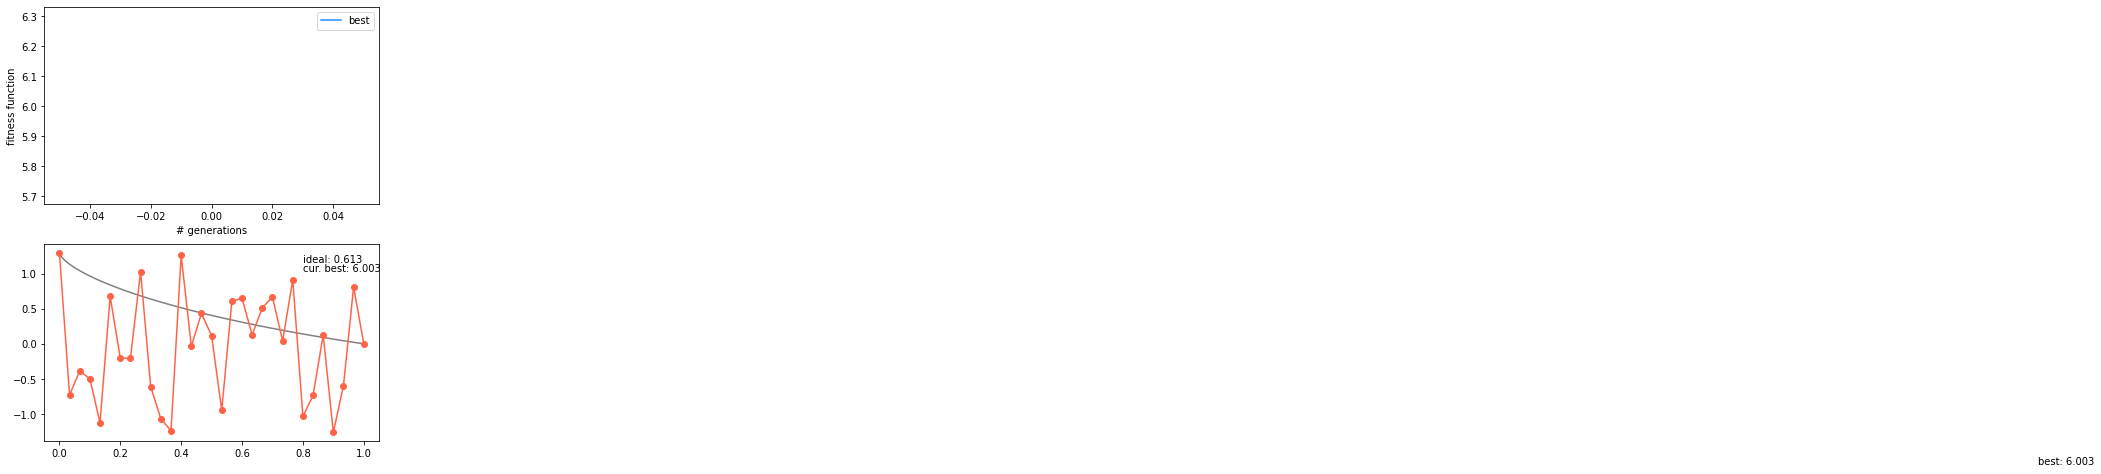

In [8]:
fig, axes = plt.subplots(2,1,figsize=(6,8))
ax_FF = axes[0]
ax_state = axes[1]

show_plot = False

if show_plot:
    plt.show(block=False)

N = 30
height = 1.3
b = Brachistochrone(N=N, height=height)

y = torch.tensor(b.state[1:-1], requires_grad=True)

#adam_optimizer = optim.Adam([y])
adam_optimizer = optim.RMSprop([y])

best = []

t_range = 3000
for t in range(t_range):

    J = fitnessFunction(y, height)

    best.append(J.item())

    b.state[1:-1] = y.detach().tolist()
    ax_FF.clear()
    ax_state.clear()
    plotFF(ax_FF, best)
    b.plotState(ax_state, color='tomato', plot_sol=True, plot_label=True)

    if show_plot:
        fig.canvas.draw()

    if make_gif:
        if t==0 or (t%max(1, int(t_range/N_gif_frames))==0):
            plt.savefig(f'{gif_dir}/{t+1}.png')

    if t%int(t_range/20)==0:
        print('iteration {}, loss: {:.3f}'.format(t, J.item()))

    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()


plt.savefig(f'{misc_runs_dir}/{base_name}.png')

if make_gif:
    # filepaths
    fp_in = gif_dir + "/*.png"
    fp_out = gif_dir + f'image{counter+1}.gif'
    make_dir(fp_in, fp_out)


In [ ]:
 
from PIL import Image, ImageTk

fp_out = gif_dir + '/image.gif'

canvas = Image.new("RGB",(100,100),"white")
gif = Image.open(fp_out, 'r')
frames = []
try:
    while 1:
        frames.append(gif.copy())
        gif.seek(len(frames))
except EOFError:
    print(EOFError)
    pass

for frame in frames:
     canvas.paste(frame)
     canvas.show()

<class 'EOFError'>


In [ ]:
import tkinter as tk
from PIL import Image, ImageTk
from itertools import count, cycle
 
class ImageLabel():
    """
    A Label that displays images, and plays them if they are gifs
    :im: A PIL Image instance or a string filename
    """
    def load(self, im):
        if isinstance(im, str):
            im = Image.open(im)
        frames = []
 
        try:
            for i in count(1):
                frames.append(ImageTk.PhotoImage(im.copy()))
                im.seek(i)
        except EOFError:
            pass
        self.frames = cycle(frames)
 
        try:
            self.delay = im.info['duration']
        except:
            self.delay = 100
 
        if len(frames) == 1:
            self.config(image=next(self.frames))
        else:
            self.next_frame()
 
    def unload(self):
        self.config(image=None)
        self.frames = None
 
    def next_frame(self):
        if self.frames:
            self.config(image=next(self.frames))
            self.after(self.delay, self.next_frame)
 
#demo :
lbl = ImageLabel()

fp_out = gif_dir + '/image.gif'
lbl.load(fp_out)
root.mainloop()

RuntimeError: ignored

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Build GIF
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in [gif_dir + "/1.png", gif_dir + "/1021.png", gif_dir + "/1051.png", gif_dir + "/1081.png"]:
        image = imageio.imread(filename)
        writer.append_data(image)

In [18]:
![token](https://media.giphy.com/media/3oD3YveOJWdwIAfZ5e/giphy.gif)

/bin/bash: -c: line 0: syntax error near unexpected token `https://media.giphy.com/media/3oD3YveOJWdwIAfZ5e/giphy.gif'
/bin/bash: -c: line 0: `[token](https://media.giphy.com/media/3oD3YveOJWdwIAfZ5e/giphy.gif)'



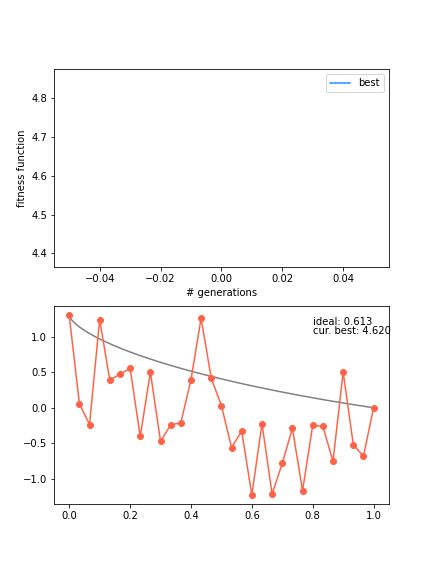

In [19]:


show_gif('mygif.gif')

In [16]:
from IPython.display import Image
Image(filename='mygif.gif')  

ValueError: ignored

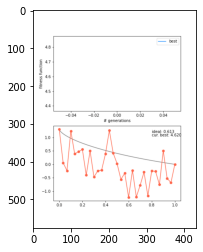

In [15]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

img = mpimg.imread("mygif.gif")

plt.imshow(img)